# 자연어처리 과제 4 (7주차)
* 과제는 해당 .ipynb 파일에 코드 작성
    * 코드는 google colab의 gpu를 사용하는 런타임 환경에서 모두실행을 통해 한번에 실행 되어야함
    * 생성형 AI (ChatGPT, Copilot, Claude, ...) 등 사용 가능
        * 단, 사용시 사용한 방법, 입력, 출력을 캡처해 보고서에 기입
* Word를 통해 자유형식으로 보고서를 작성
    * 보고서의 양식은 자유
    * 보고서의 제출은 .pdf 형식으로 제출해야하며, 파일명은 "학번_이름_HW_??.pdf"로 제출 할 것
    * 보고서에 코드를 그대로 복붙 하지 말 것 (캡처 도구를 활용, 환경 설치 자료 참고)
* .ipynb와 .pdf 파일을 el을 통해 제출
    * 예시 : "2232036006_임상훈_HW_01.ipynb"와 "2232036006_임상훈_HW_01.pdf"를 제출

## 1. Attention Heatmap 출력 및 분석 (50점)

* Transformer 모델의 Attention distribution을 Heatmap 형식으로 출력하시오.
    * Attention Heatmap을 출력한 후 비교, 분석 하시오
        * 학습전, 학습후(최소 10epoch 이상)의 차이
        * Head별 분석
        * Layer 별 분석

**GRADING**
* Heatmap 출력 (+20점)
* Heatmap 비교 분석 (+30점)

In [2]:
import os
import re
import shutil
import zipfile
import numpy as np
import unicodedata
import urllib3
import random
import math

In [3]:
import requests

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

def download_zip(url, output_path):
    response = requests.get(url, headers=headers, stream=True)
    if response.status_code == 200:
        with open(output_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"ZIP file downloaded to {output_path}")
    else:
        print(f"Failed to download. HTTP Response Code: {response.status_code}")

url = "http://www.manythings.org/anki/fra-eng.zip"
output_path = "fra-eng.zip"

if not os.path.exists(output_path):
    download_zip(url, output_path)

    path = os.getcwd()
    zipfilename = os.path.join(path, output_path)

    with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
        zip_ref.extractall(path)

In [4]:
def to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
  sent = to_ascii(sent.lower())
  sent = re.sub(r"([?.!,¿])", r" \1", sent)
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)
  sent = re.sub(r"\s+", " ", sent)
  return sent

In [5]:
def load_preprocessed_data():
  encoder_input, decoder_input = [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      src_line, tar_line, _ = line.strip().split('\t')

      src_line = [w for w in preprocess_sentence(src_line).split()]
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("[SOS] " + tar_line + " [EOS]").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)

  return encoder_input, decoder_input

sents_en_in, sents_fra_in = load_preprocessed_data()

In [6]:
def split_data(data, train_ratio=0.7, shuffle=True):
    data = list(data)
    if shuffle:
        random.shuffle(data)
    n_train = int(len(data) * train_ratio)
    train_data = data[:n_train]
    test_data = data[n_train:]
    return train_data, test_data

train_test_ratio = 0.9
train, test = split_data(zip(sents_en_in, sents_fra_in), train_test_ratio)
train, vali = split_data(train, train_test_ratio)

In [7]:
from collections import Counter

en_token_cnt = Counter()
fr_token_cnt = Counter()

for tokens, _ in train:
    en_token_cnt.update(tokens)

min_count = 2
en_vocab = {"[PAD]": 0, "[UNK]": 1, "[SOS]": 2, "[EOS]": 3}
for token, count in en_token_cnt.items():
    if count > min_count and token not in en_vocab:
        en_vocab[token] = len(en_vocab)


for _, tokens in train:
    fr_token_cnt.update(tokens)

fr_vocab = {"[PAD]": 0, "[UNK]": 1, "[SOS]": 2, "[EOS]": 3}
for token, count in fr_token_cnt.items():
    if count > min_count and token not in fr_vocab:
        fr_vocab[token] = len(fr_vocab)

In [8]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [9]:
class EnToFrDataset(Dataset):
    def __init__(self, data, en_vocab, fr_vocab):
        self.enc_input = []
        self.dec_input = []
        for en_sent, fr_sent_in in data:
            self.enc_input.append(en_sent)
            self.dec_input.append(fr_sent_in)
        self.en_vocab = en_vocab
        self.fr_vocab = fr_vocab
        self.max_len = 30

    def __len__(self):
        return len(self.enc_input)

    def __getitem__(self, idx):
        src_sample = [self.en_vocab.get(w, self.en_vocab.get("[UNK]")) for w in self.enc_input[idx]]
        trg_sample = [self.fr_vocab.get(w, self.fr_vocab.get("[UNK]")) for w in self.dec_input[idx]]
        src_sample = src_sample[:self.max_len]
        trg_sample = trg_sample[:self.max_len]
        src_sample += [self.en_vocab.get("[PAD]")] * (self.max_len - len(src_sample))
        trg_sample += [self.fr_vocab.get("[PAD]")] * (self.max_len - len(trg_sample))

        return {"src": torch.LongTensor(src_sample), "trg": torch.LongTensor(trg_sample)}

In [10]:
train_dataset = EnToFrDataset(train, en_vocab, fr_vocab)
vali_dataset = EnToFrDataset(vali, en_vocab, fr_vocab)
test_dataset = EnToFrDataset(test, en_vocab, fr_vocab)

train_loader = DataLoader(train_dataset, batch_size=64,drop_last=True, shuffle=True, num_workers=8)
vali_loader = DataLoader(vali_dataset, batch_size=64,drop_last=True, shuffle=False, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64,drop_last=True, shuffle=False, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [11]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask):
        batch_size = q.size(0)

        q = self.Wq(q)
        k = self.Wk(k)
        v = self.Wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        attn = torch.matmul(q, k.permute(0, 1, 3, 2)) / math.sqrt(self.depth)
        attn = attn.masked_fill(mask.unsqueeze(1) == 0, -1e9)
        attn = torch.nn.functional.softmax(attn, dim=-1)
        # print(attn.size())
        # print(attn)

        out = torch.matmul(attn, v)

        out = out.permute(0, 2, 1, 3).contiguous()
        out = out.view(batch_size, -1, self.d_model)

        return self.dense(out), attn

In [12]:
class TransformerEncodeLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(TransformerEncodeLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, x, padding_mask):
        attn_output, _ = self.mha(x, x, x, padding_mask)
        attn_output = self.dropout1(attn_output)

        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2

In [13]:
class TrasnformerDecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(TrasnformerDecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dff),
            nn.ReLU(),
            nn.Linear(dff, d_model)
        )
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn1, _ = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(x + attn1)

        attn2, attn_dist = self.mha2(out1, enc_output, enc_output, padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(out1 + attn2)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(out2 + ffn_output)

        return out3, attn_dist

In [14]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate):
        super(TransformerEncoder, self).__init__()
        self.enc_layers = nn.ModuleList([TransformerEncodeLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, padding_mask):
        for enc_layer in self.enc_layers:
            x = enc_layer(x, padding_mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate):
        super(TransformerDecoder, self).__init__()
        self.dec_layers = nn.ModuleList([TrasnformerDecoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, look_ahead_mask, padding_mask):
        attn_dist = {}
        for i, dec_layer in enumerate(self.dec_layers):
            x, dist = dec_layer(x, enc_output, look_ahead_mask, padding_mask)
            attn_dist['Layer{}'.format(i+1)] = dist
        return x, attn_dist

In [15]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, dff, dropout_rate, en_vocab_size, fr_vocab_size):
        super(Transformer, self).__init__()
        self.output_dim = fr_vocab_size
        self.en_Embedding = nn.Embedding(en_vocab_size, d_model)
        self.fr_Embedding = nn.Embedding(fr_vocab_size, d_model)

        self.encoder = TransformerEncoder(num_layers, d_model, num_heads, dff, dropout_rate)
        self.decoder = TransformerDecoder(num_layers, d_model, num_heads, dff, dropout_rate)
        self.final_layer = nn.Linear(d_model, fr_vocab_size)

    def encode(self, enc_input, enc_padding_mask):
        return self.encoder(self.en_Embedding(enc_input), enc_padding_mask)

    def decode(self, dec_input, enc_output, look_ahead_mask, dec_padding_mask):
        return self.decoder(self.fr_Embedding(dec_input), enc_output, look_ahead_mask, dec_padding_mask)

    def forward(self, enc_input, dec_input, enc_padding_mask, look_ahead_mask, dec_padding_mask):
        enc_output = self.encode(enc_input, enc_padding_mask)
        dec_output, attn_dist = self.decode(dec_input, enc_output, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)
        return final_output, attn_dist

In [16]:
from typing import Any
import lightning as pl

class TransformerPL(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterian = nn.CrossEntropyLoss(ignore_index=0)
        self.save_hyperparameters()

    def make_pad_mask(self, query, key, pad_idx=0):
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        key_mask = key.ne(pad_idx).unsqueeze(1)
        key_mask = key_mask.repeat(1, query_seq_len, 1)

        query_mask = query.ne(pad_idx).unsqueeze(2)
        query_mask = query_mask.repeat(1,  1, key_seq_len)

        mask = key_mask & query_mask
        mask.requires_grad = False
        return mask.to(query.device)

    def make_causal_mask(self, query, pad_idx=0):
        seq_len = query.size(1)
        causal_mask = ~torch.triu(torch.ones(seq_len, seq_len, dtype=torch.bool), diagonal=1).unsqueeze(0)
        return causal_mask.to(query.device)

    def forward(self, src, trg):
        enc_padding_mask = self.make_pad_mask(src, src)
        dec_padding_mask = self.make_pad_mask(trg, src)
        look_ahead_mask = self.make_causal_mask(trg)

        outputs, _ = self.model(src, trg, enc_padding_mask, look_ahead_mask, dec_padding_mask)

        return outputs

    def training_step(self, batch, batch_idx):
        src = batch["src"]
        trg = batch["trg"]

        outputs = self(src, trg)

        outputs_dim = outputs.shape[-1]
        outputs = outputs[:,:-1].reshape(-1, outputs_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = self.criterian(outputs, trg)

        self.log("train_loss", loss, prog_bar=True)
        self.log("train_PPL", math.exp(loss))
        return loss

    def validation_step(self, batch, batch_idx):
        src = batch["src"]
        trg = batch["trg"]

        outputs = self(src, trg)

        outputs_dim = outputs.shape[-1]
        outputs = outputs[:,:-1].reshape(-1, outputs_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = self.criterian(outputs, trg)

        self.log("val_loss", loss)
        self.log("val_PPL", math.exp(loss))
        return loss

    def test_step(self, batch, batch_idx):
        src = batch["src"]
        trg = batch["trg"]

        outputs = self(src, trg)

        outputs_dim = outputs.shape[-1]
        outputs = outputs[:,:-1].reshape(-1, outputs_dim)
        trg = trg[:, 1:].reshape(-1)
        loss = self.criterian(outputs, trg)

        self.log("test_loss", loss)
        self.log("test_PPL", math.exp(loss))
        return loss

    def decode(self, src):
        enc_output = self.model.encode(src, self.make_pad_mask(src, src))
        trg_len = 30
        outputs = [2]
        input = torch.LongTensor([[2] for _ in range(src.size(0))]).to(src.device)
        for t in range(1, trg_len):
            look_ahead_mask = self.make_causal_mask(input)
            dec_padding_mask = self.make_pad_mask(input, src)
            output, _ = self.model.decode(input, enc_output, look_ahead_mask, dec_padding_mask)
            output = self.model.final_layer(output)
            output = output[:,-1,:]
            top1 = output.argmax(1)
            outputs.append(top1.item())
            if top1.item() == 3:
                break
            input = torch.cat([input, top1.unsqueeze(1)], dim=1)
        return outputs

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        return optimizer

    def get_attention_distribution(self, src, trg):
        enc_padding_mask = self.make_pad_mask(src, src)
        dec_padding_mask = self.make_pad_mask(trg, src)
        look_ahead_mask = self.make_causal_mask(trg)

        _, attn_dist = self.model(src, trg, enc_padding_mask, look_ahead_mask, dec_padding_mask)

        return attn_dist

In [17]:
num_layers = 2
d_model = 128
num_heads = 4
dff = 512
dropout_rate = 0.1
en_vocab_size = len(en_vocab)
fr_vocab_size = len(fr_vocab)

transformer_model = Transformer(num_layers, d_model, num_heads, dff, dropout_rate, en_vocab_size, fr_vocab_size)

In [18]:
model_pl = TransformerPL(transformer_model)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


### 학습 전 Attention Distribution

In [ ]:
test_data = test_dataset.__getitem__(1000)
src = test_data["src"].unsqueeze(0)
trg = test_data["trg"].unsqueeze(0)

input = " ".join([list(en_vocab.keys())[list(en_vocab.values()).index(i)] for i in test_data["src"]])
target = " ".join([list(fr_vocab.keys())[list(fr_vocab.values()).index(i)] for i in test_data["trg"]])
print(input)
print(target)

attn_dist = model_pl.get_attention_distribution(src, trg)

you could pass for a teenager if you wore a t shirt . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[SOS] tu pourrais passer pour un adolescent si tu portais un t shirt . [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


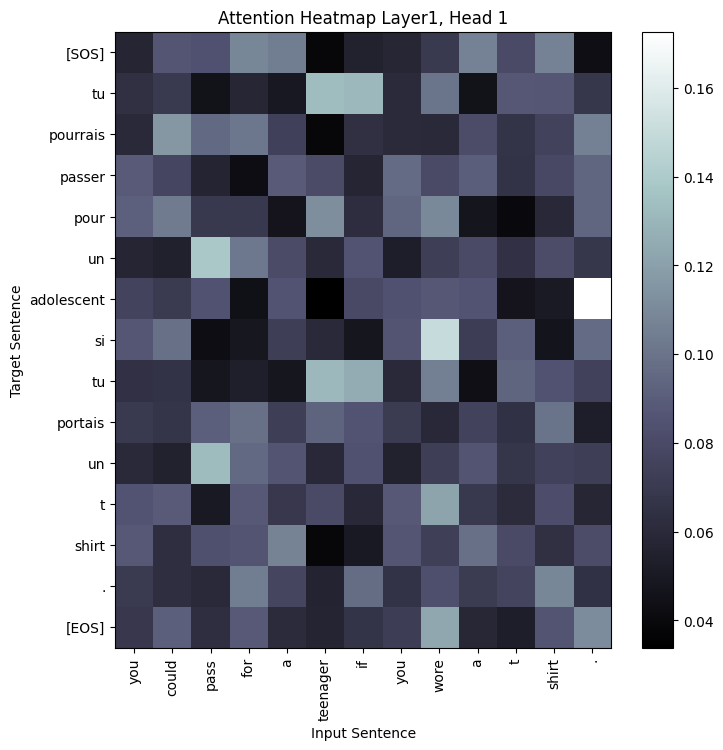

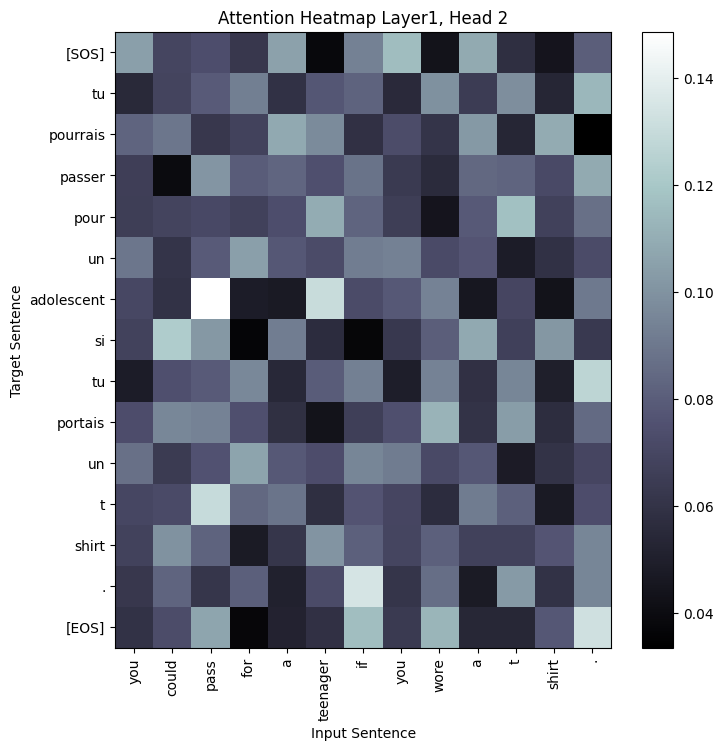

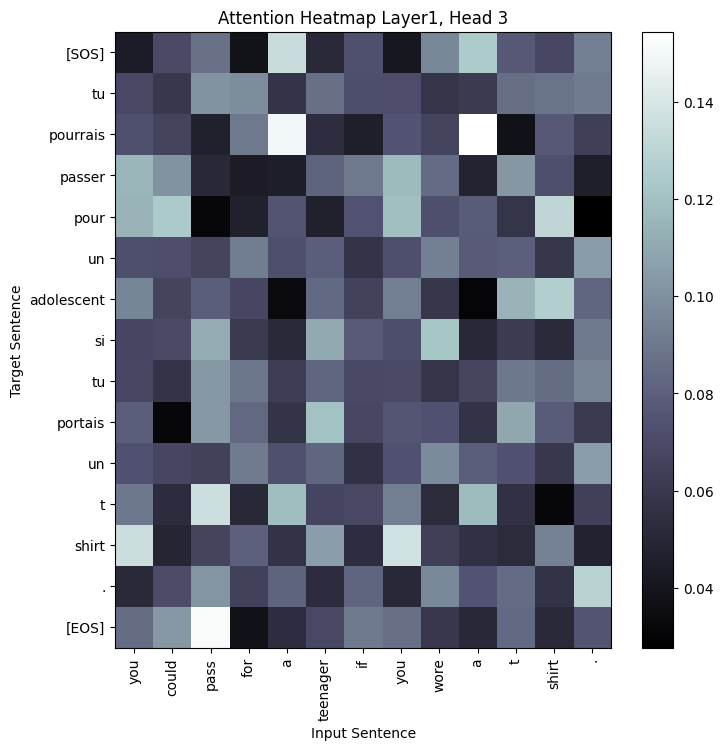

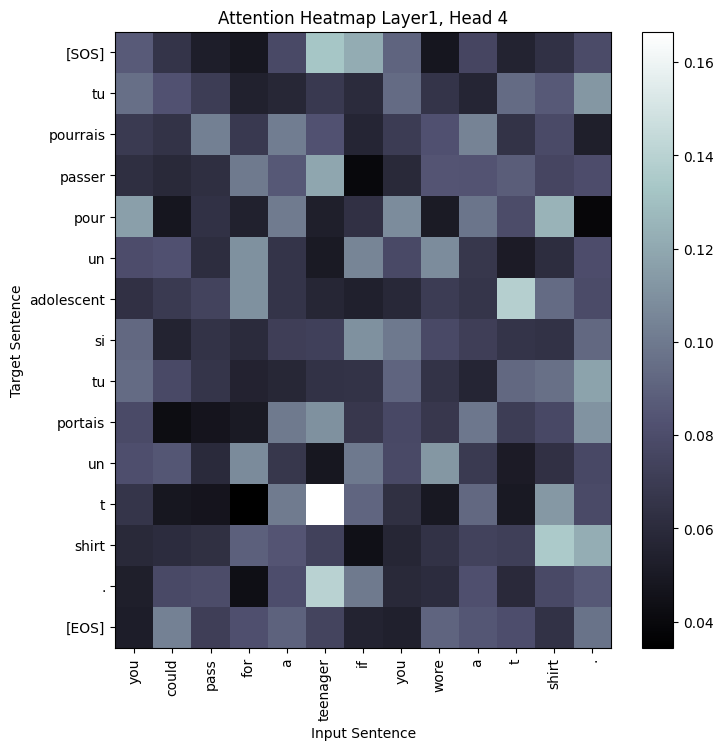

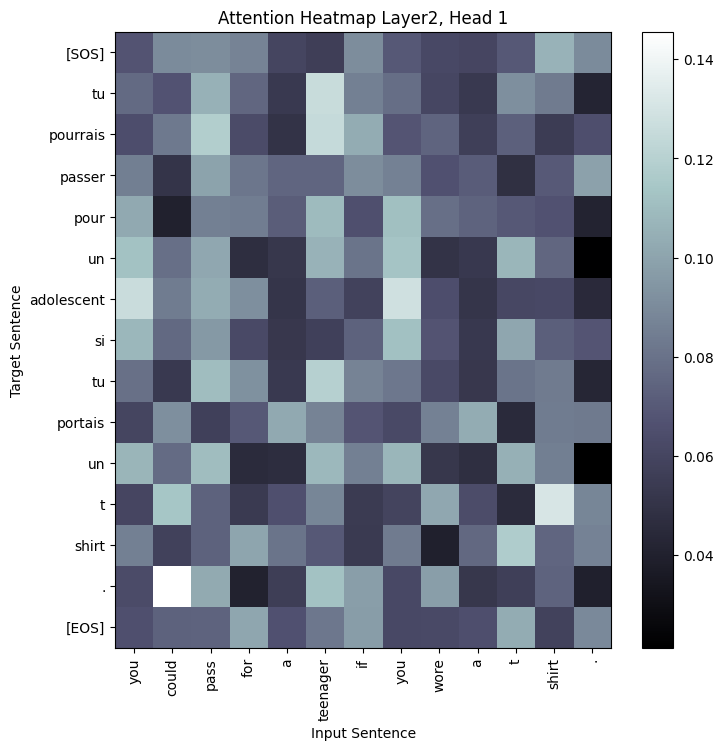

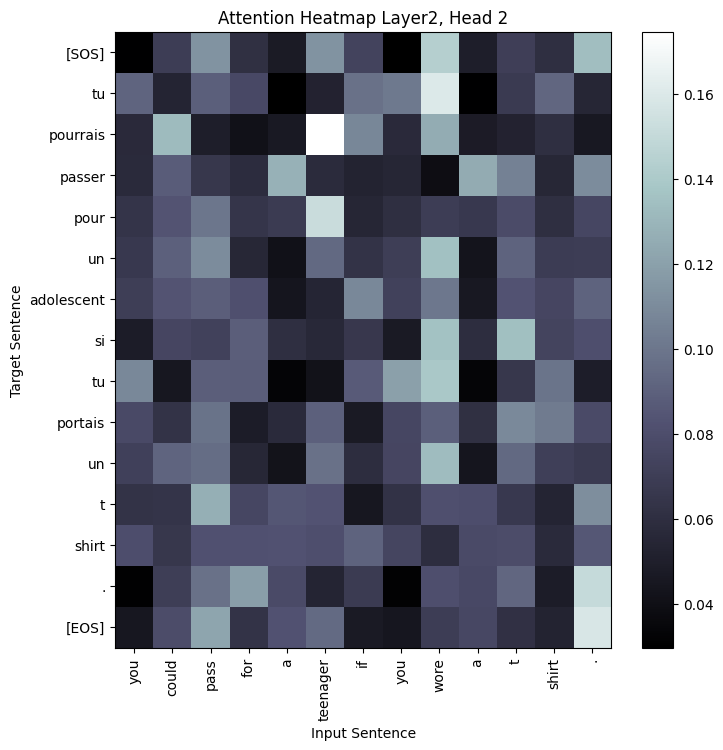

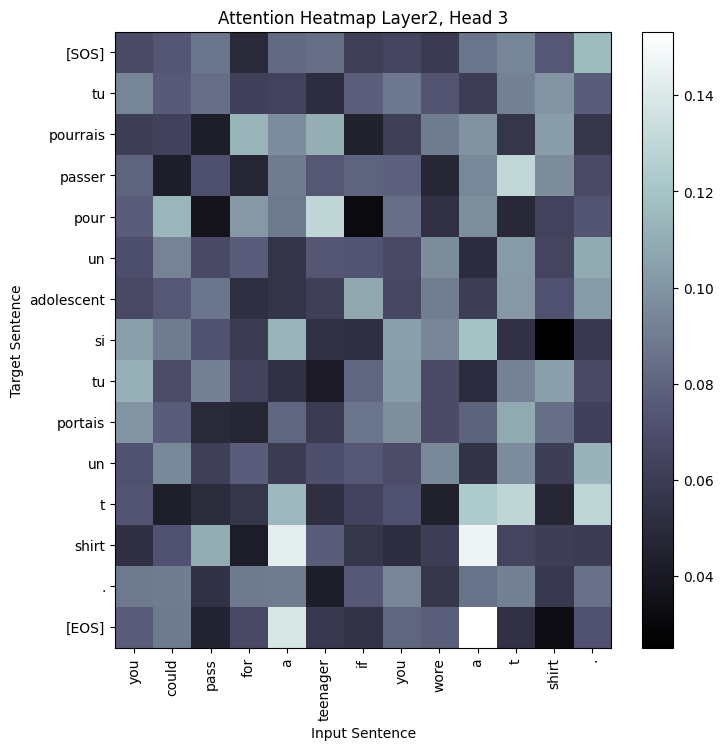

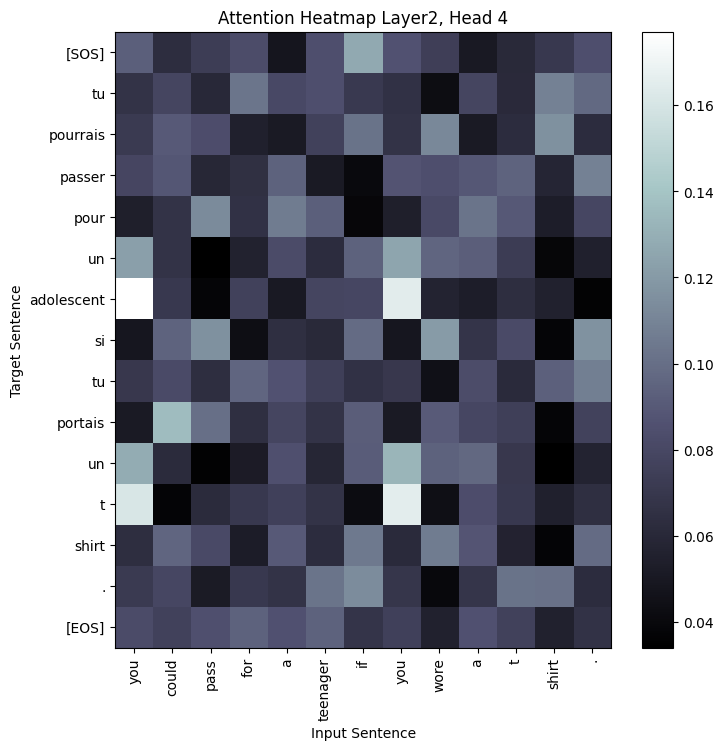

In [ ]:
from matplotlib import pyplot as plt

def plot_attention_heatmap_without_padding(attention, input, target, layer_name, head_idx):
    plt.figure(figsize=(8, 8))

    # PAD 토큰 제거
    input = [word for word in input.split() if word != '[PAD]']
    target = [word for word in target.split() if word != '[PAD]']
    attention = attention[:, :len(target), :len(input)]

    # Heatmap
    plt.imshow(attention[head_idx], cmap='bone', aspect='auto')
    plt.title(f'Attention Heatmap {layer_name}, Head {head_idx+1}')
    plt.xlabel('Input Sentence')
    plt.ylabel('Target Sentence')
    plt.xticks(np.arange(len(input)), input, rotation=90)
    plt.yticks(np.arange(len(target)), target)
    plt.colorbar()
    plt.show()

for layer_name, attention in attn_dist.items():
    num_heads = attention.size(1)
    for head_idx in range(num_heads):
        plot_attention_heatmap_without_padding(attention.squeeze(0).detach().numpy(), input, target, layer_name, head_idx)


### 10 epoch 학습 후 Attention Distributuion

In [22]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb_logger = WandbLogger(project="NLP", name="Transformer", group="HW04")

In [23]:
trainer = pl.Trainer(
    max_epochs=10,
    accelerator="gpu",
    logger=wandb_logger
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [24]:
trainer.fit(model_pl, train_loader, vali_loader)
wandb.finish()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 5.0 M 
1 | criterian | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.164    Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | Transformer      | 5.0 M 
1 | criterian | CrossEntropyLoss | 0     
-----------------------------------------------
5.0 M     Trainable params
0         Non-trainable params
5.0 M     Total params
20.164    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇████
train_PPL,█▇▇█▅▅▄▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁
train_loss,█▇██▇▆▆▅▅▅▅▄▅▃▅▄▄▄▂▄▃▃▃▃▂▃▂▂▃▂▂▁▂▂▂▂▁▂▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_PPL,█▅▄▃▂▂▂▁▁▁
val_loss,█▆▅▄▃▂▂▂▁▁
epoch,9
train_PPL,3.88078
train_loss,1.35604
trainer/global_step,29449
val_PPL,4.1694


In [ ]:
test_data = test_dataset.__getitem__(1000)
src = test_data["src"].unsqueeze(0)
trg = test_data["trg"].unsqueeze(0)

input = " ".join([list(en_vocab.keys())[list(en_vocab.values()).index(i)] for i in test_data["src"]])
target = " ".join([list(fr_vocab.keys())[list(fr_vocab.values()).index(i)] for i in test_data["trg"]])
print(input)
print(target)

attn_dist = model_pl.get_attention_distribution(src, trg)

you could pass for a teenager if you wore a t shirt . [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
[SOS] tu pourrais passer pour un adolescent si tu portais un t shirt . [EOS] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


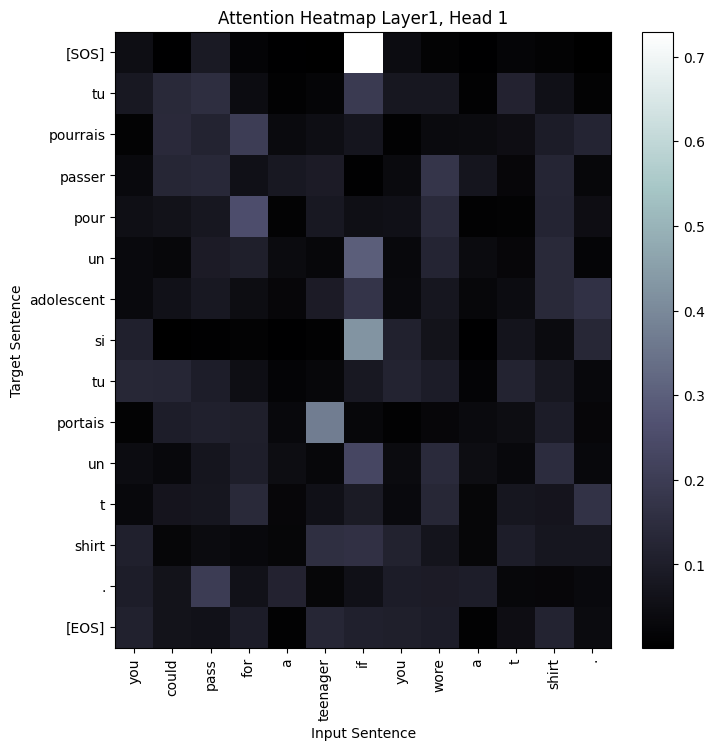

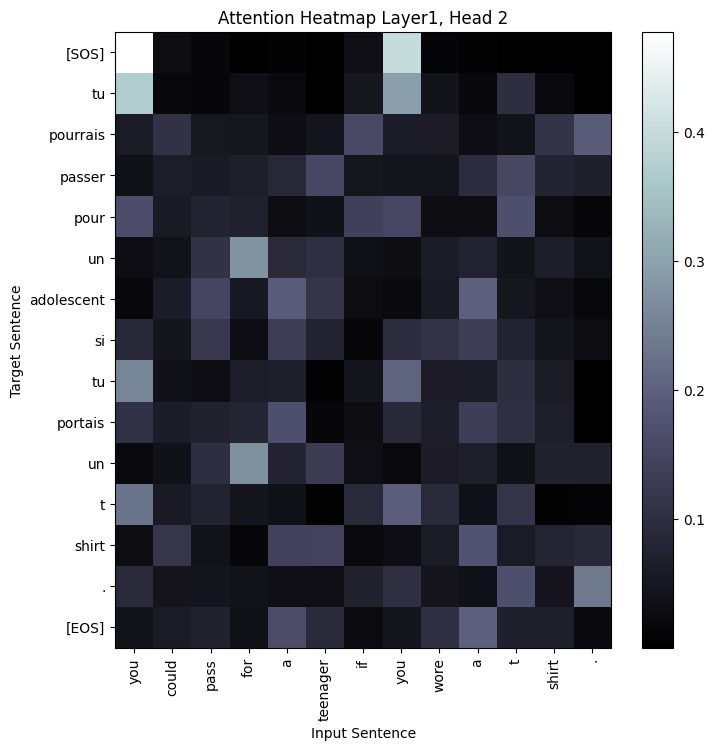

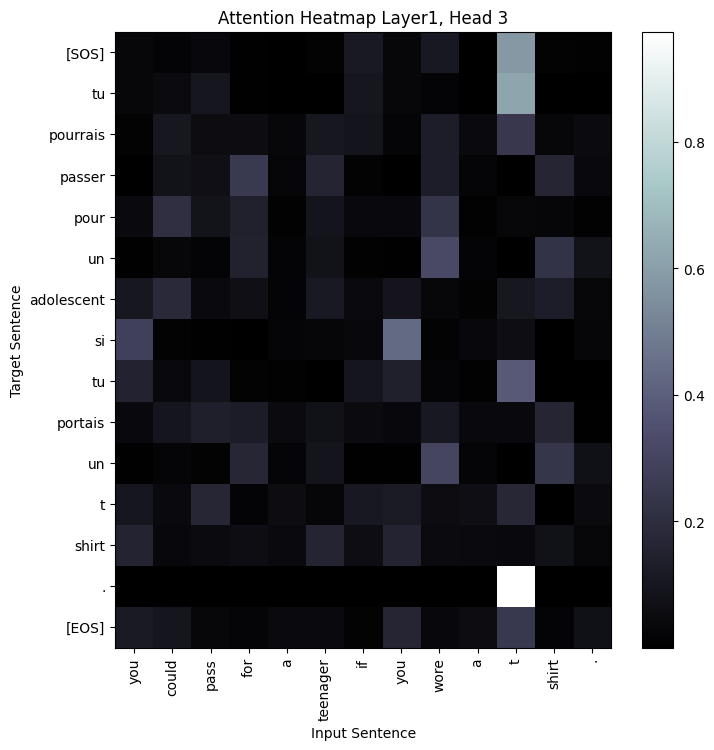

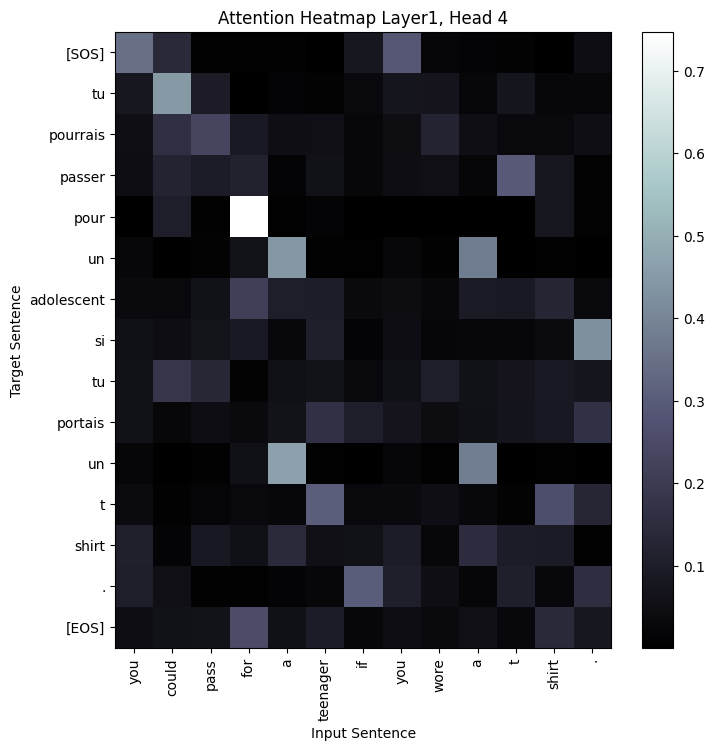

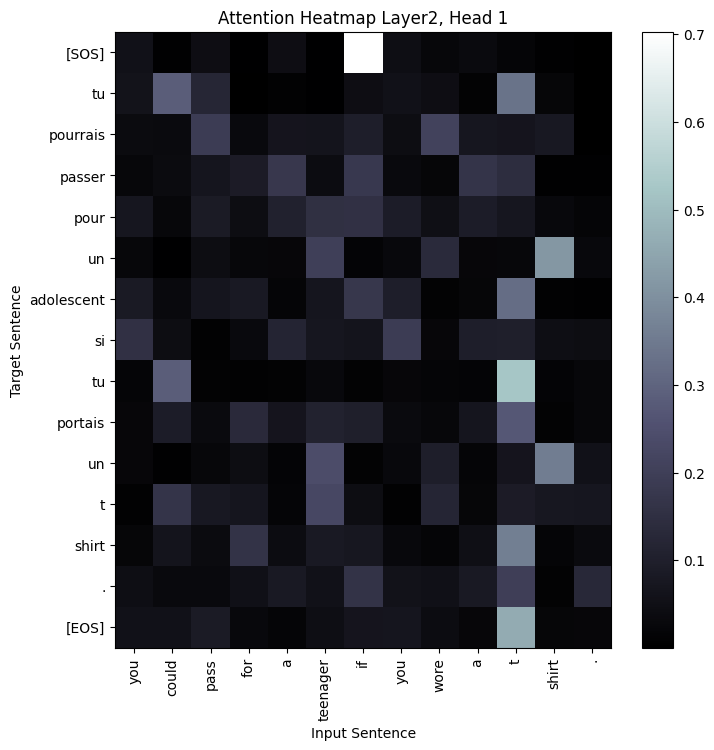

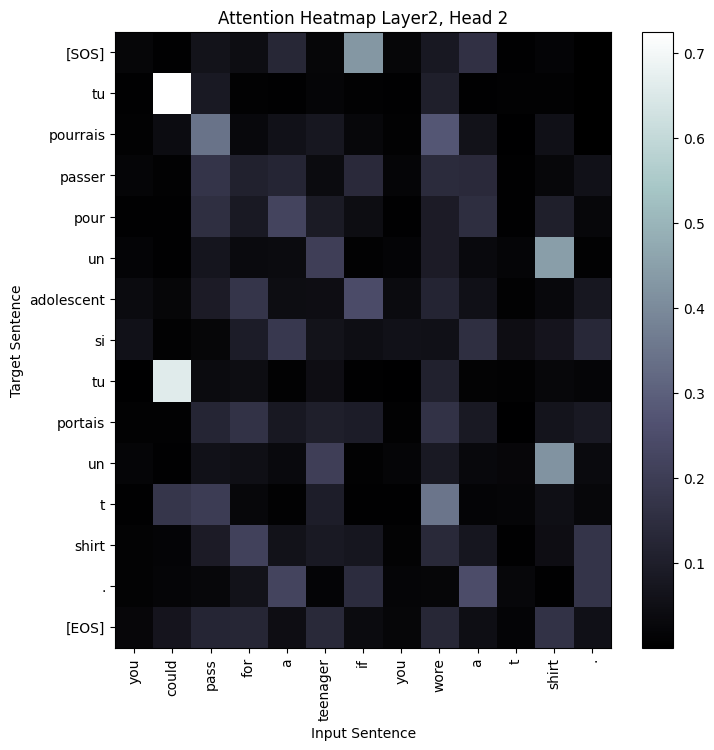

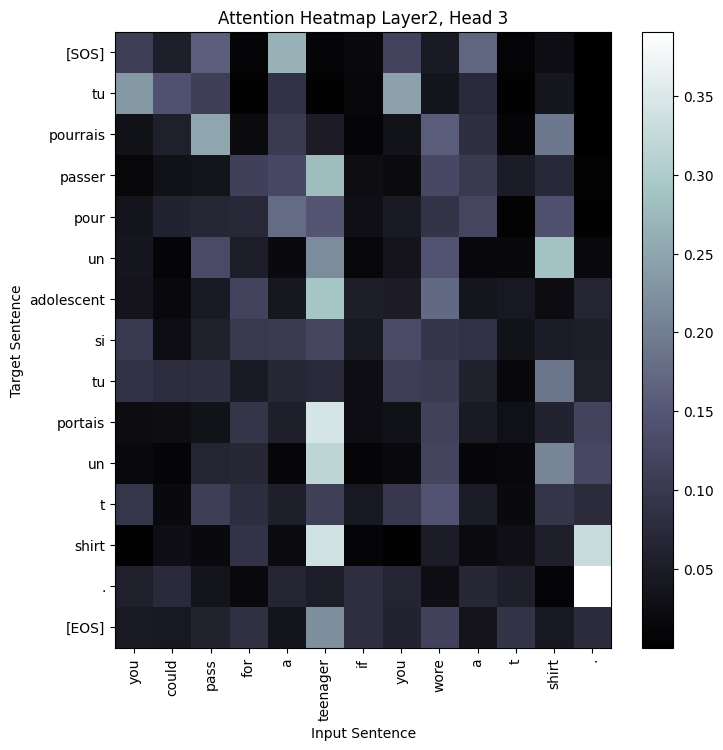

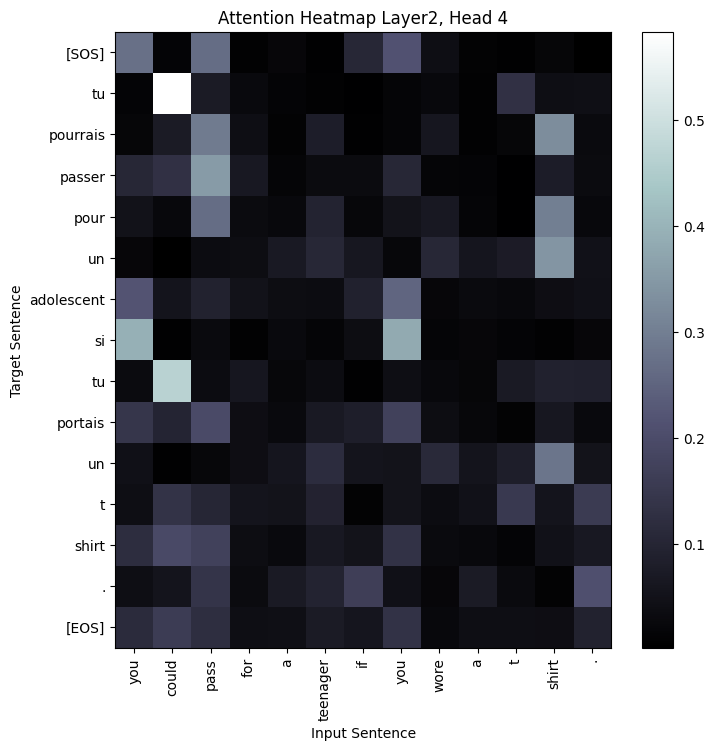

In [ ]:
from matplotlib import pyplot as plt

def plot_attention_heatmap_without_padding(attention, input, target, layer_name, head_idx):
    plt.figure(figsize=(8, 8))

    # PAD 토큰 제거
    input = [word for word in input.split() if word != '[PAD]']
    target = [word for word in target.split() if word != '[PAD]']
    attention = attention[:, :len(target), :len(input)]

    # Heatmap
    plt.imshow(attention[head_idx], cmap='bone', aspect='auto')
    plt.title(f'Attention Heatmap {layer_name}, Head {head_idx+1}')
    plt.xlabel('Input Sentence')
    plt.ylabel('Target Sentence')
    plt.xticks(np.arange(len(input)), input, rotation=90)
    plt.yticks(np.arange(len(target)), target)
    plt.colorbar()
    plt.show()

for layer_name, attention in attn_dist.items():
    num_heads = attention.size(1)
    for head_idx in range(num_heads):
        plot_attention_heatmap_without_padding(attention.squeeze(0).detach().numpy(), input, target, layer_name, head_idx)


## 2. Transformer의 장점, 단점 (50점)

* RNN 계열 모델, CNN 계열 모델에 대비 Transformer의 장단점을 서술하시오.
    * 지금까지한 실습, 과제를 기반해 근거를 제시하시오.